# YouTube Comments Sentiment Analysis 
Andie's Version <br>
Spring 2018


## 1 Set Up

### 1.1 Import Basic Modules

In [189]:
# Basics
import pandas as pd
import os
import csv
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

### 1.2 Read In Data

In [151]:
os.chdir('/Users/andiedonovan/myProjects/Youtube_Python_Project/AndiesBranch/data/') # change directory
df = pd.read_csv('OKGOcomments.csv', delimiter=";", skiprows=2, encoding='latin-1', engine='python') # read in the data

### 1.3 Clean Data Columns

In [152]:
df.columns = [
  'label',
  'comment','a','b'
]
df = df.drop(['a', 'b'], axis = 1).dropna() # drop columns 3 and 4 and missing values

### 1.4 Remove Non-Alphabetic Characters (including numbers)

In [153]:
for row in range(len(df)):
    line = df.iloc[row,1]
    df.iloc[row,1] = re.sub("[^a-zA-Z]", " ", line)

In [154]:
df.head(5)

,label,comment
0,-1.0,Everyone knows brand s papers from But No on...
1,0.0,Your paper cut balance is
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE ...
3,1.0,Blowing my mind yet again
4,0.0,Should have gone with Dunder Mifflin


## 2 Natural Language Processing

### 2.1 Import Packages

In [155]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

### 2.2 Tokenize Words

In [156]:
df['com_token']=df['comment'].str.lower().str.split()

### 2.2 Remove Stop Words

In [157]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

df['com_remv']=df['com_token'].apply(lambda x: [y for y in x if y not in sw])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andiedonovan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.3 Lemmatization and Stemming

In [158]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

df["com_lemma"] = df['com_remv'] \
    .apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization

df['com_stem']=df['com_lemma'] \
    .apply(lambda x : [ps.stem(y) for y in x]) # stemming

## 3 Data Transformations

### 3.1 Split into Training and Test Data

In [159]:
import sklearn # machine learning
from sklearn.model_selection import train_test_split # splitting up data

In [160]:
df["com_stem_str"] = df["com_stem"].apply(', '.join)

In [161]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                    df["com_stem_str"], df["label"], 
                                    test_size=0.25, 
                                    random_state=42)

### 3.2 Check for missing values

In [162]:
print('lengths training variables: ', len(X_train),",", len(Y_train))
print('lengths testing variables: ', len(X_test),",", len(Y_test), '\n')

print('Are there any missing values?', 
      '\n * Training:', pd.isnull(X_train).values.any(), ',', pd.isnull(Y_train).values.any(), 
      '\n * Testing: ', pd.isnull(X_test).values.any(), ",", pd.isnull(Y_test).values.any())


lengths training variables:  1495 , 1495
lengths testing variables:  499 , 499 

Are there any missing values? 
 * Training: False , False 
 * Testing:  False , False


### 3.3 Transform Data to Counts 

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [190]:
tfidf = TfidfVectorizer()
xtrain = tfidf.fit_transform(X_train) # transform and fit training data
xtest = tfidf.transform(X_test) # transform test data from fitted transformer

data_transformed = tfidf.fit_transform(df["com_stem_str"]) # transform entire dataset for cross validation

## 4 Machine Learning Models

In [165]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn import svm # support vector machine
from sklearn import metrics # for accuracy/ precision
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent

### 4.1 Multinomial Naive Bayes Model

**Fitting the Model:**

In [166]:
mnb = MultinomialNB()
mnb.fit(xtrain, Y_train) # fit the model on the training data word counts and training data lables

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Model Predictions:** 

In [167]:
mnb_predict = mnb.predict(xtest) # make our y predictions (labels) on the comment test data
mnb_acc = metrics.accuracy_score(Y_test, mnb_predict)
print('We obtained ', round(mnb_acc, 6), '% accuracy for the model')

We obtained  0.625251 % accuracy for the model


**Classification Report**

In [168]:
print(metrics.classification_report(Y_test, mnb_predict))

             precision    recall  f1-score   support

       -1.0       0.83      0.09      0.17       106
        0.0       0.59      0.83      0.69       226
        1.0       0.67      0.69      0.68       167

avg / total       0.67      0.63      0.58       499



**Confusion Matrix**

In [169]:
metrics.confusion_matrix(Y_test, mnb_predict)

array([[ 10,  76,  20],
       [  2, 187,  37],
       [  0,  52, 115]])

**Cross Validation of Accuracy:**

In [170]:
scores = cross_val_score(mnb, data_transformed, df["label"], cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confidence Interval for Accuracy: 0.64 (+/- 0.03)


### 4.2 Logistic Regression

**Fitting the Model:**

In [171]:
lr = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class="multinomial") # set multinomial setting for multiclass data

**Model Predictions:**

In [172]:
lr.fit(xtrain, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [173]:
lr_predict = lr.predict(xtest)
lr_acc = metrics.accuracy_score(Y_test, lr_predict)
print('We obtained ', round(lr_acc, 6), '% accuracy for the logistic regression model')

We obtained  0.655311 % accuracy for the logistic regression model


**Classification Report:**

In [174]:
print(metrics.classification_report(Y_test, lr_predict))

             precision    recall  f1-score   support

       -1.0       0.73      0.28      0.41       106
        0.0       0.61      0.82      0.70       226
        1.0       0.74      0.66      0.70       167

avg / total       0.68      0.66      0.64       499



**Confusion Matrix:**

In [175]:
metrics.confusion_matrix(Y_test, lr_predict)

array([[ 30,  65,  11],
       [ 11, 186,  29],
       [  0,  56, 111]])

**Cross Validation:**

In [176]:
scores = cross_val_score(lr, data_transformed, df["label"], cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confidence Interval for Accuracy: 0.65 (+/- 0.03)


### 4.3 Linear Support Vector Machine

**Fitting the Model & Predictions:**

In [177]:
svm = svm.SVC()
svm.fit(xtrain, Y_train)
svm_predict = svm.predict(xtest)
svm_acc = metrics.accuracy_score(Y_test, svm_predict)
print('We obtained ', round(svm_acc, 6), '% accuracy for the SVM model')

We obtained  0.452906 % accuracy for the SVM model


**Classification Report:**

In [178]:
print(metrics.classification_report(Y_test, mnb_predict))

             precision    recall  f1-score   support

       -1.0       0.83      0.09      0.17       106
        0.0       0.59      0.83      0.69       226
        1.0       0.67      0.69      0.68       167

avg / total       0.67      0.63      0.58       499



**Confusion Matrix:**

In [179]:
metrics.confusion_matrix(Y_test, lr_predict)

array([[ 30,  65,  11],
       [ 11, 186,  29],
       [  0,  56, 111]])

**Cross Validation:**

In [180]:
scores = cross_val_score(svm, data_transformed, df["label"], cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confidence Interval for Accuracy: 0.45 (+/- 0.00)


### 5.1 K-Nearest Neighbor

**Fitting Model & Predictions:**

In [181]:
from sklearn.neighbors import KNeighborsClassifier # k-NN ensemble method

knn = KNeighborsClassifier()
knn.fit(xtrain, Y_train)

knn_predict = knn.predict(xtest)
knn_acc = metrics.accuracy_score(Y_test, knn_predict)
print('We obtained ', round(knn_acc, 6), '% accuracy for the KNN Bagging model')

We obtained  0.531062 % accuracy for the KNN Bagging model


**Cross Validation:**

In [182]:
scores = cross_val_score(knn, data_transformed, df["label"], cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confidence Interval for Accuracy: 0.54 (+/- 0.03)


### 5.3 Random Forest

**Fitting Model & Predictions:**

In [183]:
from sklearn.ensemble import RandomForestClassifier # random forest ensemble method

ranfor = RandomForestClassifier(n_estimators=10, random_state=10)
ranfor = ranfor.fit(xtrain, Y_train)

rf_predict = ranfor.predict(xtest)
rf_acc = metrics.accuracy_score(Y_test, rf_predict)
print('We obtained ', round(rf_acc, 6), '% accuracy for the Random Forest model')

We obtained  0.653307 % accuracy for the Random Forest model


**Cross Validation:**

In [184]:
scores = cross_val_score(ranfor, data_transformed, df["label"], cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confidence Interval for Accuracy: 0.62 (+/- 0.05)


## 6 Data Visualizations

### 6.1 Table of Model Results

In [185]:
myTable = pd.DataFrame(columns=['Naive Bayes','Support Vect Machine','Logistic Regression', 'K-NN', 'Random Forest'],
                   index=["Accuracy"])
myTable['Naive Bayes']=mnb_acc; myTable['Support Vect Machine']=svm_acc; myTable['Logistic Regression']=lr_acc
myTable['K-NN']= knn_acc; myTable['Random Forest']= rf_acc
myTable

,Naive Bayes,Support Vect Machine,Logistic Regression,K-NN,Random Forest
Accuracy,0.625251,0.452906,0.655311,0.531062,0.653307


In [186]:
labels = list(myTable.columns.values)
values = myTable.iloc[0].values
ypos = np.arange(len(labels))

In [187]:
myTable.iloc[0].values

array([0.6252505 , 0.45290581, 0.65531062, 0.53106212, 0.65330661])

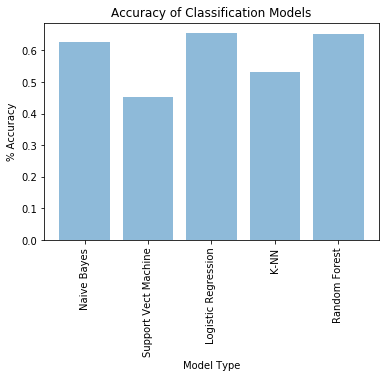

In [188]:
plt.bar(ypos, values, align='center', alpha=0.5)
plt.xticks(ypos, labels); plt.ylabel('% Accuracy')
plt.xlabel('Model Type'); plt.title('Accuracy of Classification Models')
plt.xticks(rotation=90); plt.show()

## 7 Final Remarks

From the five different machine learning models attempted, Linear Support Vector Machine gave the lowest accuracy (45.3%) while Multinomial Logistic Regression gave the highest (65.5%). Upon first glance, 65% accuracy seems fairly low--however, considering that this was a multinomial classification task (Positive, Neutral or Negative), 65% is significantly higher than a random distribution. Furthermore, because the data was from YouTube comments rather than from a formal body of text, the corpus contained a higher frequency of spelling errors, slang, emojis, names, and foreign languages than would otherwise be expected, all of which added noise to the models. Future advancements may focus on better recognizing and processing these attributes common to social media textual data. 